In [2]:
from preprocessing import load_reviews
from experiments import run_experiment
from features import SentimentFeatures
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import random

[nltk_data] Downloading package punkt to /home/janek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2025-11-27 22:12:01.473322: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Setup

In [3]:
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
train_df, test_df, val_df = load_reviews("word")
train_df.head()

I0000 00:00:1764277942.582744   37510 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-11-27 22:12:23.318539: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-11-27 22:12:27.138326: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-27 22:12:31.125374: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,review,sentiment,units
0,This was an absolutely terrible movie. Don't b...,0,"[this, was, an, absolutely, terrible, movie, d..."
1,"I have been known to fall asleep during films,...",0,"[i, have, been, known, to, fall, asleep, durin..."
2,Mann photographs the Alberta Rocky Mountains i...,0,"[mann, photographs, the, alberta, rocky, mount..."
3,This is the kind of film for a snowy Sunday af...,1,"[this, is, the, kind, of, film, for, a, snowy,..."
4,"As others have mentioned, all the women that g...",1,"[as, others, have, mentioned, all, the, women,..."


In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['units'])

train_df["concept_ids"] = tokenizer.texts_to_sequences(train_df['units'])
test_df["concept_ids"] = tokenizer.texts_to_sequences(test_df['units'])

In [11]:
# Number of unique tokens in the tokenizer
num_unique_tokens = len(tokenizer.word_index)  # word_index maps token -> unique ID
print("Number of unique tokens:", num_unique_tokens)
train_df.head()

Number of unique tokens: 74127


,review,sentiment,units,concept_ids,concept_ids_positive_features,concept_ids_negative_features,concept_ids_important_features
0,This was an absolutely terrible movie. Don't b...,0,"[this, was, an, absolutely, terrible, movie, d...","[10, 13, 33, 412, 376, 17, 42, 12, 27, 10363, ...","[33, 8, 32, 1317, 453, 191, 87, 200, 67, 208, ...","[10, 13, 412, 376, 17, 42, 12, 27, 10363, 3190...","[10, 13, 33, 412, 376, 17, 42, 12, 27, 10363, ..."
1,"I have been known to fall asleep during films,...",0,"[i, have, been, known, to, fall, asleep, durin...","[9, 24, 82, 545, 6, 775, 2314, 301, 107, 18, 1...","[545, 301, 107, 5, 662, 3, 2175, 4, 563, 2209,...","[9, 24, 82, 6, 2314, 18, 10, 607, 6, 177, 64, ...","[9, 24, 82, 545, 6, 2314, 301, 107, 18, 10, 5,..."
2,Mann photographs the Alberta Rocky Mountains i...,0,"[mann, photographs, the, alberta, rocky, mount...","[3526, 6019, 1, 24047, 4744, 3902, 8, 3, 867, ...","[3526, 6019, 1, 4744, 3902, 8, 3, 867, 2, 1870...","[193, 31, 295, 6, 42, 18, 207, 23, 24048, 81, ...","[3526, 6019, 1, 4744, 3902, 8, 3, 867, 2, 1870..."
3,This is the kind of film for a snowy Sunday af...,1,"[this, is, the, kind, of, film, for, a, snowy,...","[10, 5, 1, 215, 4, 19, 15, 3, 8613, 2528, 2575...","[5, 1, 4, 19, 3, 8613, 2528, 2575, 53, 1, 4, 1...","[10, 215, 345, 69, 137, 21, 85, 3028, 357, 605...","[10, 5, 1, 215, 4, 19, 3, 8613, 2528, 2575, 53..."
4,"As others have mentioned, all the women that g...",1,"[as, others, have, mentioned, all, the, women,...","[14, 389, 24, 1013, 29, 1, 342, 11, 137, 2452,...","[14, 389, 1, 8, 19, 1456, 1, 54, 10589, 275, 1...","[24, 1013, 29, 342, 11, 137, 2452, 10, 22, 642...","[14, 389, 24, 1013, 29, 1, 342, 11, 137, 2452,..."


# Feature selection

In [12]:
an = SentimentFeatures()
an.fit(train_df["concept_ids"], train_df["sentiment"])

In [13]:
num_important_features = int(num_unique_tokens * 0.2)
train_df = an.add_top_features(train_df, n=num_important_features)
test_df  = an.add_top_features(test_df, n=num_important_features)

# Models

In [14]:
train_df.head(2000)

,review,sentiment,units,concept_ids,concept_ids_positive_features,concept_ids_negative_features,concept_ids_important_features
0,This was an absolutely terrible movie. Don't b...,0,"[this, was, an, absolutely, terrible, movie, d...","[10, 13, 33, 412, 376, 17, 42, 12, 27, 10363, ...","[33, 8, 32, 1317, 453, 191, 87, 200, 67, 208, ...","[10, 13, 412, 376, 17, 42, 12, 27, 10363, 3190...","[10, 13, 33, 412, 376, 17, 42, 12, 27, 10363, ..."
1,"I have been known to fall asleep during films,...",0,"[i, have, been, known, to, fall, asleep, durin...","[9, 24, 82, 545, 6, 775, 2314, 301, 107, 18, 1...","[545, 301, 107, 5, 662, 3, 2175, 4, 563, 2209,...","[9, 24, 82, 6, 2314, 18, 10, 607, 6, 177, 64, ...","[9, 24, 82, 545, 6, 2314, 301, 107, 18, 10, 5,..."
2,Mann photographs the Alberta Rocky Mountains i...,0,"[mann, photographs, the, alberta, rocky, mount...","[3526, 6019, 1, 24047, 4744, 3902, 8, 3, 867, ...","[3526, 6019, 1, 4744, 3902, 8, 3, 867, 2, 1870...","[193, 31, 295, 6, 42, 18, 207, 23, 24048, 81, ...","[3526, 6019, 1, 4744, 3902, 8, 3, 867, 2, 1870..."
3,This is the kind of film for a snowy Sunday af...,1,"[this, is, the, kind, of, film, for, a, snowy,...","[10, 5, 1, 215, 4, 19, 15, 3, 8613, 2528, 2575...","[5, 1, 4, 19, 3, 8613, 2528, 2575, 53, 1, 4, 1...","[10, 215, 345, 69, 137, 21, 85, 3028, 357, 605...","[10, 5, 1, 215, 4, 19, 3, 8613, 2528, 2575, 53..."
4,"As others have mentioned, all the women that g...",1,"[as, others, have, mentioned, all, the, women,...","[14, 389, 24, 1013, 29, 1, 342, 11, 137, 2452,...","[14, 389, 1, 8, 19, 1456, 1, 54, 10589, 275, 1...","[24, 1013, 29, 342, 11, 137, 2452, 10, 22, 642...","[14, 389, 24, 1013, 29, 1, 342, 11, 137, 2452,..."
...,...,...,...,...,...,...,...
1995,I turn on 700 Club once in awhile and only agr...,0,"[i, turn, on, club, once, in, awhile, and, onl...","[9, 449, 23, 1267, 271, 8, 5132, 2, 63, 1004, ...","[271, 8, 2, 16, 4, 1, 28, 4, 109, 5, 1159, 32,...","[9, 449, 23, 1267, 5132, 63, 49, 6863, 91, 9, ...","[9, 449, 23, 1267, 271, 8, 5132, 2, 63, 16, 49..."
1996,"Something about ""Paulie"" touched my heart as f...",1,"[something, about, paulie, touched, my, heart,...","[139, 43, 3672, 2791, 60, 456, 14, 165, 99, 42...","[3672, 2791, 60, 456, 14, 5, 3, 1880, 234, 887...","[139, 43, 165, 99, 42, 7, 160, 17, 9, 98, 10, ...","[139, 43, 3672, 2791, 60, 456, 14, 165, 99, 42..."
1997,This Hitchcock movie bears little similarity t...,0,"[this, hitchcock, movie, bears, little, simila...","[10, 2353, 17, 3235, 116, 7490, 6, 26, 288, 80...","[2353, 3235, 116, 26, 288, 107, 2, 52, 3, 54, ...","[10, 17, 6, 180, 76, 37, 357, 11, 31, 251, 96,...","[10, 2353, 17, 3235, 116, 6, 26, 288, 107, 2, ..."
1998,"What's inexplicable? Firstly, the hatred towar...",1,"[what, is, inexplicable, firstly, the, hatred,...","[47, 5, 5661, 4623, 1, 3629, 916, 10, 17, 7, 1...","[5, 1, 3629, 916, 194, 1, 801, 4, 57, 3, 3129,...","[47, 5661, 4623, 10, 17, 7, 12, 27, 17, 29, 18...","[47, 5, 5661, 4623, 1, 3629, 916, 10, 17, 7, 1..."


# Word Sequences

In [15]:
# Median number of concepts per review
median_all = int(train_df["concept_ids"].apply(len).median())
median_pos = int(train_df["concept_ids_positive_features"].apply(len).median())
median_neg = int(train_df["concept_ids_negative_features"].apply(len).median())
median_imp = int(train_df["concept_ids_important_features"].apply(len).median())

print(f"Median concepts per review: all={median_all}, positive={median_pos}, negative={median_neg}, important={median_imp}")

Median concepts per review: all=177, positive=86, negative=82, important=167


In [16]:
# --- Prepare datasets ---
X_all_train = pad_sequences(train_df["concept_ids"], maxlen=median_all, padding='post')
X_pos_train = pad_sequences(train_df["concept_ids_positive_features"], maxlen=median_pos, padding='post')
X_neg_train = pad_sequences(train_df["concept_ids_negative_features"], maxlen=median_neg, padding='post')
X_imp_train = pad_sequences(train_df["concept_ids_important_features"], maxlen=median_imp, padding='post')
y_train = train_df["sentiment"]

X_all_test = pad_sequences(test_df["concept_ids"], maxlen=median_all, padding='post')
X_pos_test = pad_sequences(test_df["concept_ids_positive_features"], maxlen=median_pos, padding='post')
X_neg_test = pad_sequences(test_df["concept_ids_negative_features"], maxlen=median_neg, padding='post')
X_imp_test = pad_sequences(test_df["concept_ids_important_features"], maxlen=median_imp, padding='post')
y_test = test_df["sentiment"]

In [18]:
print(f"Number of unique concepts: {num_unique_tokens}")
print(f"Training set size: {len(X_all_train)}")
print(f"Test set size: {len(X_all_test)}")
print(f"Sequence lengths - All: {median_all}, Positive: {median_pos}, Negative: {median_neg}")

# Prepare data in the required dictionary format
X_sets_train = {
    'all': X_all_train,
    'pos': X_pos_train, 
    'neg': X_neg_train,
    'important': X_imp_train
}

X_sets_test = {
    'all': X_all_test,
    'pos': X_pos_test,
    'neg': X_neg_test,
    'important': X_imp_test
}

sequence_lengths = {
    'all': median_all,
    'pos': median_pos, 
    'neg': median_neg,
    'important': median_imp
}

# Verify shapes
print("\nData shapes:")
for key in X_sets_train:
    print(f"Train {key}: {X_sets_train[key].shape}")
for key in X_sets_test:
    print(f"Test {key}: {X_sets_test[key].shape}")

print(f"\nLabel shapes: y_train {y_train.shape}, y_test {y_test.shape}")

Number of unique concepts: 74127
Training set size: 25000
Test set size: 20000
Sequence lengths - All: 177, Positive: 86, Negative: 82

Data shapes:
Train all: (25000, 177)
Train pos: (25000, 86)
Train neg: (25000, 82)
Train important: (25000, 167)
Test all: (20000, 177)
Test pos: (20000, 86)
Test neg: (20000, 82)
Test important: (20000, 167)

Label shapes: y_train (25000,), y_test (20000,)


## LSTM


LSTM Model 'all' Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 177, 32)        │     2,372,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,380,961 (9.08 MB)

 Trainable params: 2,380,961 (9.08 MB)

 Non-trainable params: 0 (0.00 B)


Training LSTM Model 'all'...
Epoch 1/20


2025-11-27 22:18:49.043386: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6107 - loss: 0.6687 - precision: 0.6178 - recall: 0.5740 - val_accuracy: 0.7322 - val_loss: 0.5825 - val_precision: 0.6878 - val_recall: 0.8625 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5337 - loss: 0.6942 - precision: 0.5394 - recall: 0.4411 - val_accuracy: 0.5930 - val_loss: 0.6946 - val_precision: 0.5631 - val_recall: 0.8748 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5888 - loss: 0.6790 - precision: 0.6097 - recall: 0.4863 - val_accuracy: 0.7406 - val_loss: 0.6058 - val_precision: 0.6829 - val_recall: 0.9103 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5911 - loss: 0.6571 - precision: 0.5912 - recall: 0.5828 - val_accuracy: 0.5424 - val_loss: 0.6878 - val_precision: 0.5692 - val_recall: 0.3947 - learning_rate: 0.0010
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.54

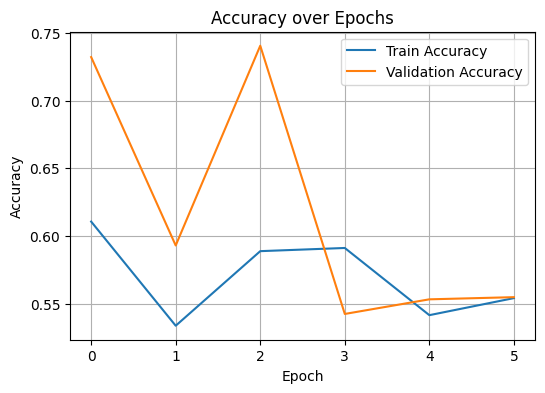


=== ALL EVALUATION ===
Accuracy: 0.7367
              precision    recall  f1-score   support

           0     0.8187    0.6081    0.6978     10000
           1     0.6883    0.8653    0.7667     10000

    accuracy                         0.7367     20000
   macro avg     0.7535    0.7367    0.7323     20000
weighted avg     0.7535    0.7367    0.7323     20000


=== ALL MODEL ===
Accuracy: 0.7367


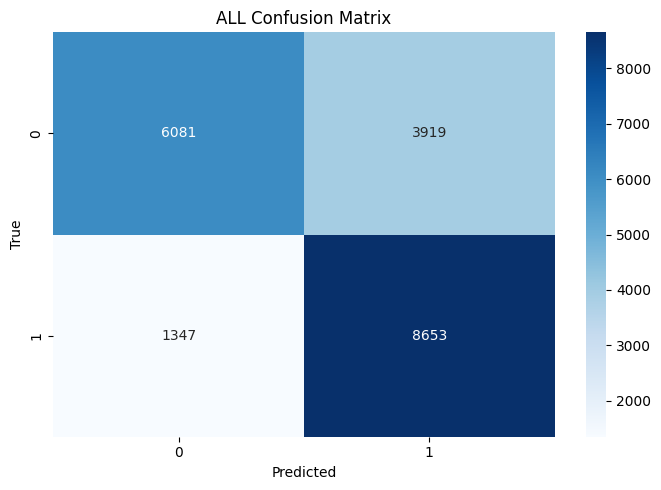

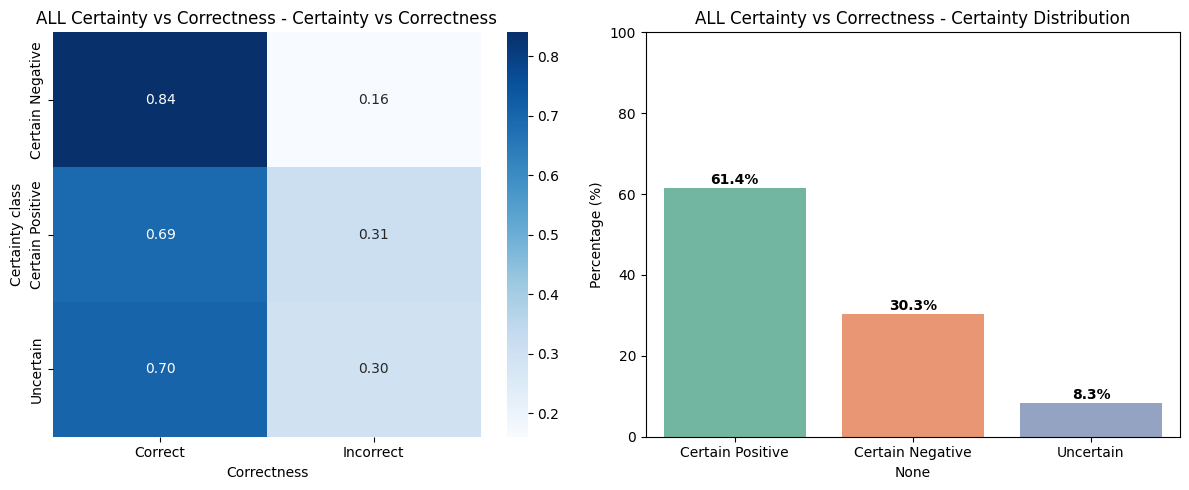


ALL MODEL - Unsure Predictions (probability near 0.3-0.7):
Probability [0.45], Label [0]: "This show is not clever. That's basically what it boils down to. The "original humor" that these writers try to pull off to avoid completely biting off the rest of the worlds bush bashing is just unfunny. In another comment, someone quotes a couple hilarious lines. The standout for me was George H.W. Bush telling the kids they're not supposed to watch any TV besides Fox News. Wow. I thought the episodes I saw were bad. The fact that this line is a high point for the series is pathetic.<br /><br />My problem with drivel like this sad excuse for political satire is that these folks are getting a second season. I'm a liberal republican and I know Bush hasn't been a good president. We all do. But that's no excuse for putting out this utterly poopie waste of time. I place these writers on the same level as the geniuses behind 'Meet the Spartans'. Their formula, bite off as many already unfunny topica

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 86, 32)         │     2,372,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,380,961 (9.08 MB)

 Trainable params: 2,380,961 (9.08 MB)

 Non-trainable params: 0 (0.00 B)


Training LSTM Model 'pos'...
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6585 - loss: 0.6451 - precision: 0.6729 - recall: 0.6126 - val_accuracy: 0.6770 - val_loss: 0.6091 - val_precision: 0.8862 - val_recall: 0.4153 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.7501 - loss: 0.5673 - precision: 0.7410 - recall: 0.7665 - val_accuracy: 0.7494 - val_loss: 0.5526 - val_precision: 0.7305 - val_recall: 0.8001 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.7804 - loss: 0.5200 - precision: 0.7805 - recall: 0.7784 - val_accuracy: 0.7792 - val_loss: 0.4906 - val_precision: 0.8299 - val_recall: 0.7092 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8332 - loss: 0.4370 - precision: 0.8402 - recall: 0.8217 - val_accuracy: 0.7900 - val_loss: 0.4936 - val_precision: 0.8576 - val_recall: 0.7017 - learning_rate: 0.0010
Epoch 5/20
313/313 ━━━━━━━━━━

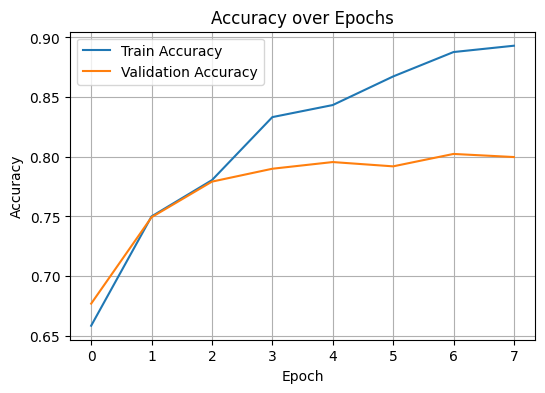


=== POS EVALUATION ===
Accuracy: 0.8268
              precision    recall  f1-score   support

           0     0.7902    0.8899    0.8371     10000
           1     0.8740    0.7637    0.8151     10000

    accuracy                         0.8268     20000
   macro avg     0.8321    0.8268    0.8261     20000
weighted avg     0.8321    0.8268    0.8261     20000


=== POS MODEL ===
Accuracy: 0.8268


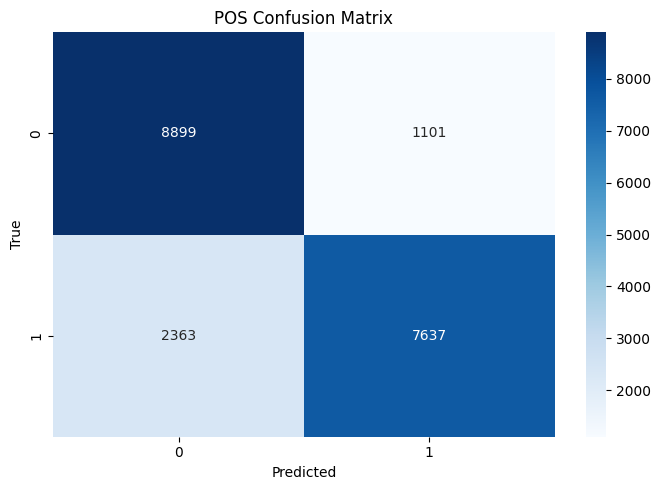

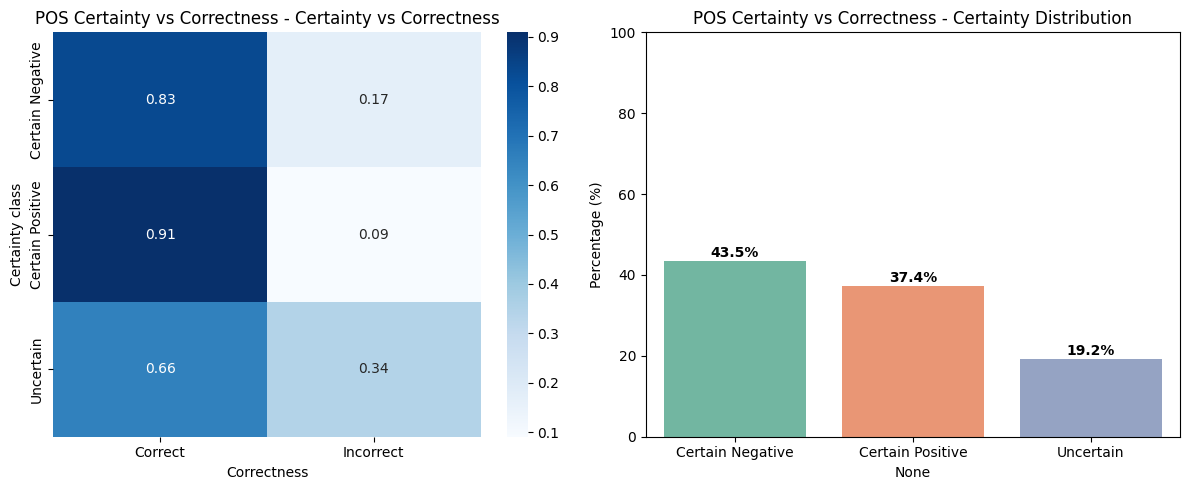


POS MODEL - Unsure Predictions (probability near 0.3-0.7):
Probability [0.37], Label [0]: "As others have mentioned, this movie is similar to THE FLY (both versions) and the lesser known sci-fi flick ALTERED STATES. The big difference is that those two movies were well made by people who knew what they were doing and were good at it. METAMORPHOSIS did not have these advantages. METAMORPHOSIS is a potentially interesting science fantasy story that had the wrong people in charge of it and the wrong actors playing the roles.<br /><br />The story follows scientist Dr. Peter Houseman (Gene LeBrock), an obsessed man working on a genetic cure to aging and death. When the university he works for threatens to cut funding, he decides to inject the anti-aging serum into himself. As a result, Dr. Houseman spends the rest of the movie slowly turning into a lizard. And oh yes, watching the good doctor go through the process of becoming that lizard is a great joy. It really is so bad that it's good.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 82, 32)         │     2,372,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,380,961 (9.08 MB)

 Trainable params: 2,380,961 (9.08 MB)

 Non-trainable params: 0 (0.00 B)


Training LSTM Model 'neg'...
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.7155 - loss: 0.5857 - precision: 0.7072 - recall: 0.7325 - val_accuracy: 0.7818 - val_loss: 0.5044 - val_precision: 0.7473 - val_recall: 0.8597 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8105 - loss: 0.4618 - precision: 0.7696 - recall: 0.8845 - val_accuracy: 0.8164 - val_loss: 0.4361 - val_precision: 0.7923 - val_recall: 0.8637 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8484 - loss: 0.3821 - precision: 0.8316 - recall: 0.8726 - val_accuracy: 0.8190 - val_loss: 0.4100 - val_precision: 0.7875 - val_recall: 0.8799 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8748 - loss: 0.3325 - precision: 0.8545 - recall: 0.9024 - val_accuracy: 0.8224 - val_loss: 0.4324 - val_precision: 0.8118 - val_recall: 0.8451 - learning_rate: 0.0010
Epoch 5/20
313/313 ━━━━━━━━━━

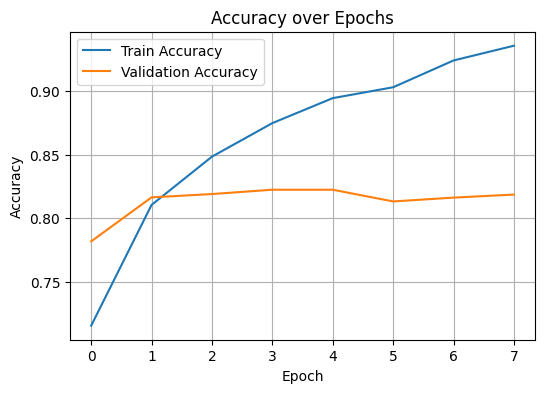


=== NEG EVALUATION ===
Accuracy: 0.8657
              precision    recall  f1-score   support

           0     0.9110    0.8105    0.8578     10000
           1     0.8293    0.9208    0.8727     10000

    accuracy                         0.8657     20000
   macro avg     0.8702    0.8657    0.8652     20000
weighted avg     0.8702    0.8657    0.8652     20000


=== NEG MODEL ===
Accuracy: 0.8657


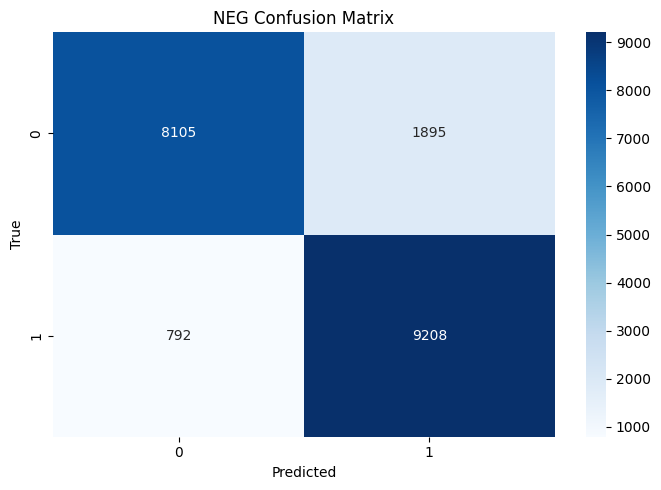

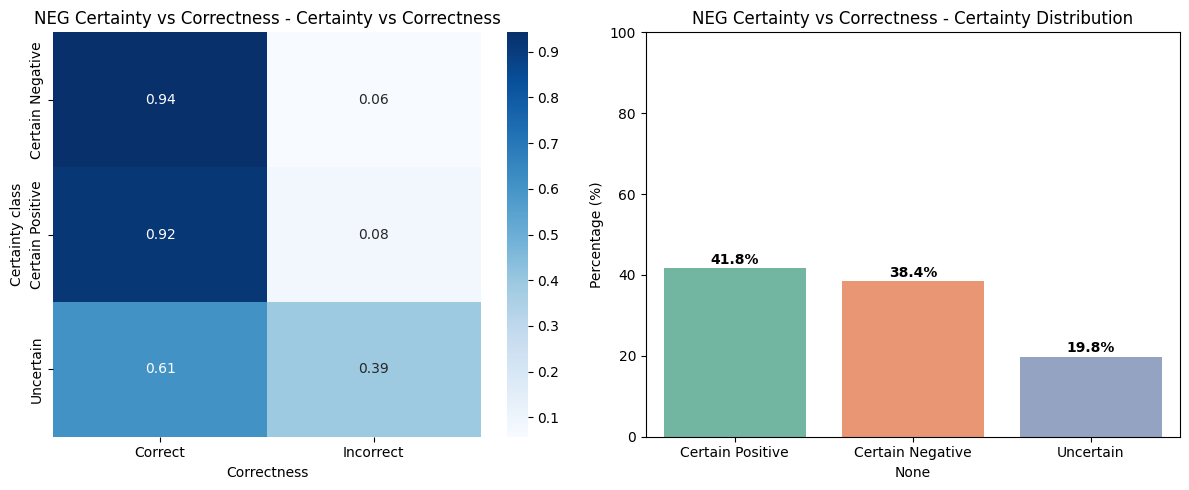


NEG MODEL - Unsure Predictions (probability near 0.3-0.7):
Probability [0.53], Label [0]: "As others have mentioned, this movie is similar to THE FLY (both versions) and the lesser known sci-fi flick ALTERED STATES. The big difference is that those two movies were well made by people who knew what they were doing and were good at it. METAMORPHOSIS did not have these advantages. METAMORPHOSIS is a potentially interesting science fantasy story that had the wrong people in charge of it and the wrong actors playing the roles.<br /><br />The story follows scientist Dr. Peter Houseman (Gene LeBrock), an obsessed man working on a genetic cure to aging and death. When the university he works for threatens to cut funding, he decides to inject the anti-aging serum into himself. As a result, Dr. Houseman spends the rest of the movie slowly turning into a lizard. And oh yes, watching the good doctor go through the process of becoming that lizard is a great joy. It really is so bad that it's good.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 167, 32)        │     2,372,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,380,961 (9.08 MB)

 Trainable params: 2,380,961 (9.08 MB)

 Non-trainable params: 0 (0.00 B)


Training LSTM Model 'important'...
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.5405 - loss: 0.6973 - precision: 0.5324 - recall: 0.6432 - val_accuracy: 0.5942 - val_loss: 0.6735 - val_precision: 0.6436 - val_recall: 0.4445 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5791 - loss: 0.6638 - precision: 0.5733 - recall: 0.6082 - val_accuracy: 0.5922 - val_loss: 0.6547 - val_precision: 0.5564 - val_recall: 0.9581 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6156 - loss: 0.6527 - precision: 0.5959 - recall: 0.7108 - val_accuracy: 0.6228 - val_loss: 0.6521 - val_precision: 0.5897 - val_recall: 0.8380 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6888 - loss: 0.6177 - precision: 0.6801 - recall: 0.7095 - val_accuracy: 0.6538 - val_loss: 0.6250 - val_precision: 0.7389 - val_recall: 0.4887 - learning_rate: 0.0010
Epoch 5/20
313/313 ━━━━

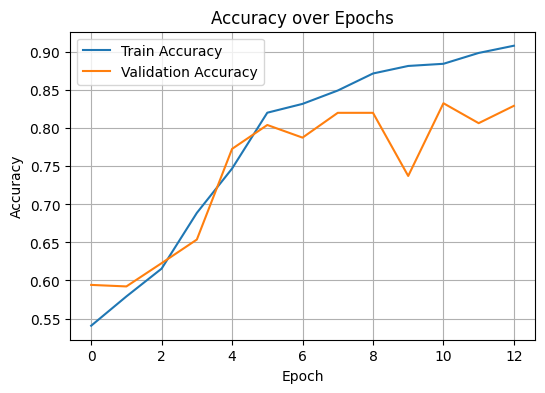


=== IMPORTANT EVALUATION ===
Accuracy: 0.8824
              precision    recall  f1-score   support

           0     0.8830    0.8816    0.8823     10000
           1     0.8818    0.8832    0.8825     10000

    accuracy                         0.8824     20000
   macro avg     0.8824    0.8824    0.8824     20000
weighted avg     0.8824    0.8824    0.8824     20000


=== IMPORTANT MODEL ===
Accuracy: 0.8824


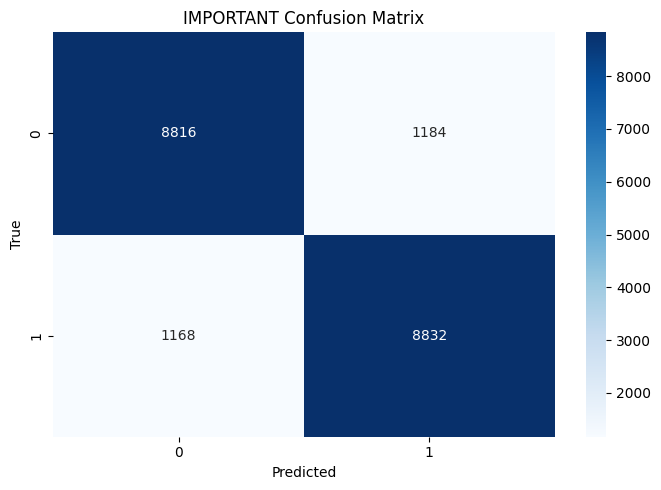

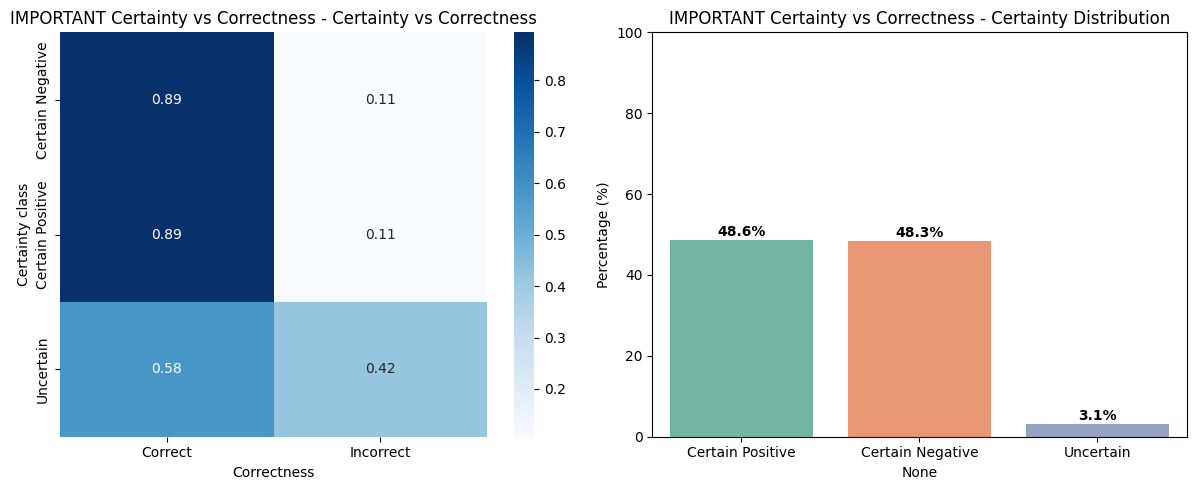


IMPORTANT MODEL - Unsure Predictions (probability near 0.3-0.7):
Probability [0.57], Label [1]: "This low-budget erotic thriller that has some good points, but a lot more bad one. The plot revolves around a female lawyer trying to clear her lover who is accused of murdering his wife. Being a soft-core film, that entails her going undercover at a strip club and having sex with possible suspects. As plots go for this type of genre, not to bad. The script is okay, and the story makes enough sense for someone up at 2 AM watching this not to notice too many plot holes. But everything else in the film seems cheap. The lead actors aren't that bad, but pretty much all the supporting ones are unbelievably bad (one girl seems like she is drunk and/or high). The cinematography is badly lit, with everything looking grainy and ugly. The sound is so terrible that you can barely hear what people are saying. The worst thing in this movie is the reason you're watching it-the sex. The reason people wat

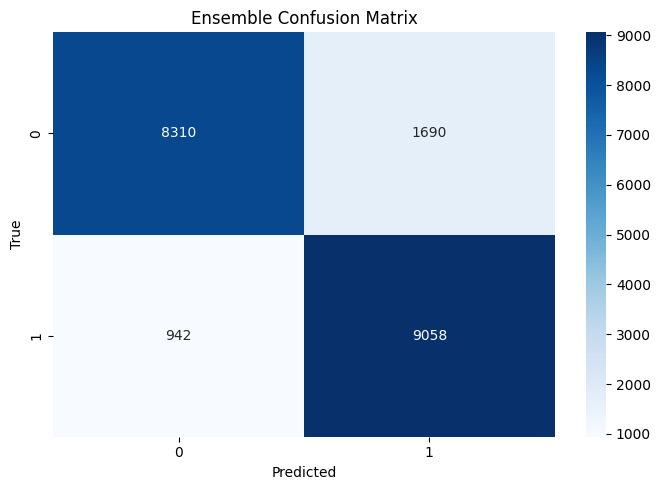

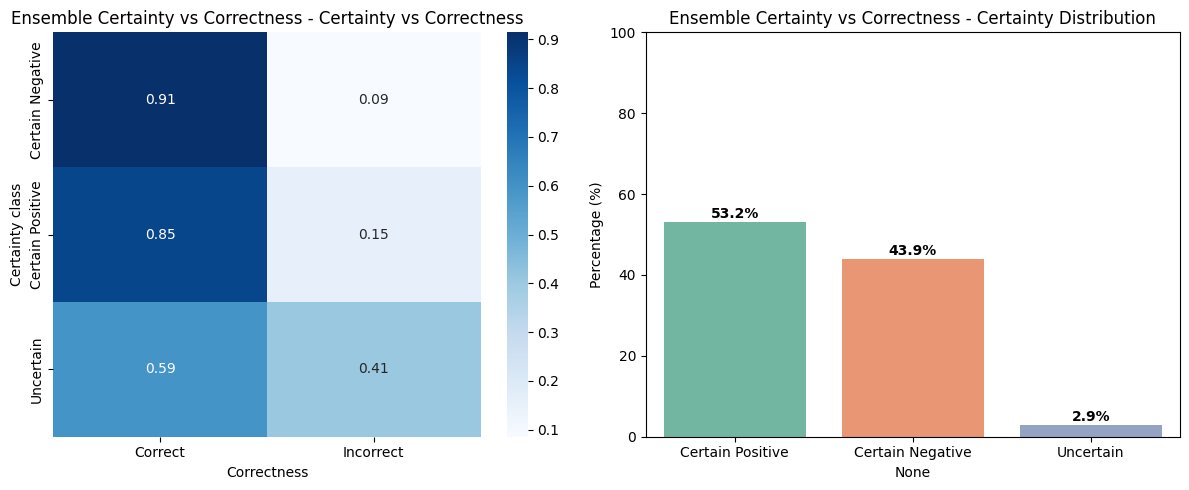


ENSEMBLE - Unsure Predictions (probability near 0.3-0.7):
Probability [0.45], Label [0]: "This show is not clever. That's basically what it boils down to. The "original humor" that these writers try to pull off to avoid completely biting off the rest of the worlds bush bashing is just unfunny. In another comment, someone quotes a couple hilarious lines. The standout for me was George H.W. Bush telling the kids they're not supposed to watch any TV besides Fox News. Wow. I thought the episodes I saw were bad. The fact that this line is a high point for the series is pathetic.<br /><br />My problem with drivel like this sad excuse for political satire is that these folks are getting a second season. I'm a liberal republican and I know Bush hasn't been a good president. We all do. But that's no excuse for putting out this utterly poopie waste of time. I place these writers on the same level as the geniuses behind 'Meet the Spartans'. Their formula, bite off as many already unfunny topical

In [19]:
results = run_experiment(X_sets_train, y_train, X_sets_test, y_test, test_df["review"], "lstm", num_unique_tokens + 1, sequence_lengths)